# Final Project

## Link to dataset
Here is a <a href="https://www.kaggle.com/lepchenkov/usedcarscatalog" target="_blank">link</a> to the dataset on Kaggle.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv('data/cars.csv')
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,...,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,...,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,...,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,...,True,False,True,True,False,False,False,False,True,7


In [3]:
df.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state',
       'drivetrain', 'price_usd', 'is_exchangeable', 'location_region',
       'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'duration_listed'],
      dtype='object')

### Drop Rows and Columns

In [4]:
electric_df = df[df['engine_type'] == 'electric']
len(electric_df)

10

Drop rows of electric vehicles because there are very few data samples of electric vehicles.

In [5]:
df.drop(electric_df.index, axis=0, inplace=True)

Drop ```"engine_fuel"``` column because it is too similar to ```"engine_type"```, which is what we are trying to predict.

In [6]:
df.drop('engine_fuel', axis=1, inplace=True)

### Find Columns with Missing Values

In [7]:
cols = df.columns[df.isna().sum()>0]
print(f'Columns with missing values: {cols.values}')

Columns with missing values: []


No missing values

### Label Encode Columns with True/False Values

Set boolean type columns to integers.

$\text{True}=1$

$\text{False}=0$

In [9]:
true_false = ['engine_has_gas', 'has_warranty', 'is_exchangeable']

df[true_false] = df[true_false].astype(int)

Columns `feature_0` to `feature_9`

In [10]:
features = []
for i in range(10):
    features.append(f'feature_{i}')
    
df[features] = df[features].astype(int)

In [11]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_has_gas,engine_type,engine_capacity,body_type,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,0,gasoline,2.5,universal,...,1,1,1,0,1,0,1,1,1,16
1,Subaru,Outback,automatic,blue,290000,2002,0,gasoline,3.0,universal,...,1,0,0,1,1,0,0,0,1,83
2,Subaru,Forester,automatic,red,402000,2001,0,gasoline,2.5,suv,...,1,0,0,0,0,0,0,1,1,151
3,Subaru,Impreza,mechanical,blue,10000,1999,0,gasoline,3.0,sedan,...,0,0,0,0,0,0,0,0,0,86
4,Subaru,Legacy,automatic,black,280000,2001,0,gasoline,2.5,universal,...,1,0,1,1,0,0,0,0,1,7


<br/>

<br/>

# Explore the Data

# TODO

Create plots to better understand the data we are working with.

$\Downarrow\text{ We don't need to keep these. This is just an idea }\Downarrow$

In [85]:
# sns.displot(df['price_usd'])
# plt.show()

In [86]:
# sns.boxplot(x=df['up_counter'])
# plt.show()

<br/>

<br/>

# Classification

Predict if the vehicle fuel is **"gasoline"** or **"diesel"**.

Label encode `engine_type` to use as label.

In [14]:
df['engine_type'] = df['engine_type'].apply(lambda x: 1 if x=='gasoline' else 0)

### `OneHotEncoder()` on categorical columns, `StandardScaler( )` on numerical data

In [15]:
# Columns with categorical data
cat_cols = ['manufacturer_name', 'model_name', 'transmission', 'color', 'year_produced', 
               'body_type', 'has_warranty', 'state', 'drivetrain', 'location_region']

# Columns with numerical data
num_cols = ['odometer_value', 'engine_capacity', 'price_usd', 'number_of_photos', 'up_counter', 'duration_listed']

transform_cols = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols),  # OneHotEncoder() on categorical data
    (StandardScaler(), num_cols),                                      # StandardScaler() on numerical data
    remainder='passthrough'                                            # Allow remainder columns to pass through 
)

### Set X and y and split into test/train

Use all the features.

Label: `engine_type`

In [16]:
X = df.drop('engine_type', axis=1)
y = df['engine_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, y_train.shape

((30816, 28), (30816,))

### Function for Stratified k-Fold Cross Validation

In [17]:
def strat_kfold(X, y, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    train_scores = []
    test_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        pipe = make_pipeline(transform_cols, clf)

        pipe.fit(X_train, y_train)

        train_scores.append(pipe.score(X_train, y_train))
        test_scores.append(pipe.score(X_test, y_test))

    max_test_score = round(max(test_scores)*100, 2)
    
    average_train_score = round(np.mean(train_scores)*100, 2)
    average_test_score = round(np.mean(test_scores)*100, 2)

    print(f'Average training accuracy: {average_train_score}%',
      f'\nAverage testing accuracy: {average_test_score}%')
    
    print(f'\nHighest testing accuracy: {max_test_score}%')
    
    return average_train_score, average_test_score

<br/>

# Logistic Regression

### Using `X_train` and `y_train` on default values

In [18]:
# Logistic regression pipeline
logreg_pipe = make_pipeline(transform_cols, LogisticRegression(max_iter=2000))

logreg_pipe.fit(X_train, y_train)

training_score = round(logreg_pipe.score(X_train, y_train)*100, 2)
testing_score = round(logreg_pipe.score(X_test, y_test)*100, 2)

print(f'Training accuracy: {training_score}%',
      f'\nTesting accuracy: {testing_score}%')

Training accuracy: 83.72% 
Testing accuracy: 82.09%


### Hyperparameter tuning

Dictionary of parameters to try.

In [19]:
# logreg_paramgrid = [
#     {'logreg__C': [100, 10, 1, 0.1, 0.01],
#      'logreg__solver': ['lbfgs', 'sag', 'saga']}
# ]

Search for the best parameters for `LogisticRegression()` using `RandomizedSearchCV()`

In [20]:
# logreg_pipe = Pipeline(steps=[('transform', transform_cols),
#                               ('logreg', LogisticRegression(max_iter=3000))])

# best_logreg = RandomizedSearchCV(logreg_pipe, logreg_paramgrid, n_iter=8, cv=5)

# best_logreg.fit(X_train, y_train)

# best_logreg.best_score_

In [21]:
# best_logreg.score(X_test, y_test)

In [22]:
# best_logreg.best_params_

**Note:** Above cells are commented out because they take hours to run.

When we ran the cells and searched for the best hyperparameters, the results were:
- Best parameters: `C = 10` and `solver = "lbfgs"`
- Best accuracy on training set: 0.83174
- Accuracy on test set: 0.82010

### Stratified k-Fold Cross Validation, k=5

Using best values from hyperparameter optimization.

In [23]:
logreg_avg_train, logreg_avg_test = strat_kfold(X, y, LogisticRegression(C=10, max_iter=4000))

Average training accuracy: 83.9% 
Average testing accuracy: 82.97%

Highest testing accuracy: 83.31%


<br/>

# Random Forest

### Using `X_train` and `y_train` on default values

In [24]:
# Random forest pipeline
rf_pipe = make_pipeline(transform_cols, RandomForestClassifier())

rf_pipe.fit(X_train, y_train)

training_score = round(rf_pipe.score(X_train, y_train)*100, 2)
testing_score = round(rf_pipe.score(X_test, y_test)*100, 2)

print(f'Training accuracy: {training_score}%',
      f'\nTesting accuracy: {testing_score}%')

Training accuracy: 100.0% 
Testing accuracy: 88.02%


### Hyperparameter Tuning

Dictionary of parameters to try.

In [25]:
rf_paramgrid = [
    {'randfor__n_estimators': list(np.arange(100,501,20)),
     'randfor__max_depth': [10, 20, 30, None],
     'randfor__min_samples_split': [2, 4, 6],
     'randfor__min_samples_leaf': [1, 2, 4]}
]

Search for the best parameters for `RandomForestClassifier()` using `RandomizedSearchCV()`

In [26]:
# rf_pipe = Pipeline(steps=[('transform', transform_cols),
#                               ('randfor', RandomForestClassifier())])
# best_rf = RandomizedSearchCV(rf_pipe, rf_paramgrid, cv=5, n_iter=30)

# best_rf.fit(X_train, y_train)

# best_rf.best_score_

In [27]:
# best_rf.score(X_test, y_test)

In [28]:
# best_rf.best_params_

**Note:** Above cells are commented out because they take hours to run.

When we ran the cells and searched for the best hyperparameters, the results were:
- Best parameters: `n_estimators = 480`, `min_samples_split = 2`, `min_samples_leaf = 1`, and `max_depth = None`
- Best accuracy on training set: 0.88194
- Accuracy on test set: 0.88072

### Stratified k-Fold Cross Validation, k=5

Using the values acquired from hyperparameter tuning. Only `n_estimators` is different from the default values.

In [29]:
rf_avg_train, rf_avg_test = strat_kfold(X, y, RandomForestClassifier(n_estimators=480))

Average training accuracy: 100.0% 
Average testing accuracy: 88.52%

Highest testing accuracy: 88.9%


<br/>

## Multi-Layer Perceptron

### Using `X_train` and `y_train` on default values

In [30]:
# Multi-layer perceptron pipeline
nn_pipe = make_pipeline(transform_cols, MLPClassifier(max_iter=1000))

nn_pipe.fit(X_train, y_train)

training_score = round(nn_pipe.score(X_train, y_train)*100, 2)
testing_score = round(nn_pipe.score(X_test, y_test)*100, 2)

print(f'Training accuracy: {training_score}%',
      f'\nTesting Accuracy: {testing_score}%')

Training accuracy: 99.75% 
Testing Accuracy: 85.81%


### Hyperparameter Tuning

Dictionary of parameters to try.

In [31]:
nn_paramgrid = [
    {'nn__hidden_layer_sizes': [(50, 50, 50), (25, 50, 25), (100,)],
     'nn__activation': ['logistic', 'relu'],
     'nn__learning_rate': ['constant', 'adaptive']}
]

Search for the best parameters for `MLPClassifier()` using `RandomizedSearchCV()`

In [32]:
# nn_pipe = Pipeline(steps=[('transform', transform_cols),
#                           ('nn', MLPClassifier(max_iter=2000))])
# best_nn = RandomizedSearchCV(nn_pipe, nn_paramgrid, cv=5, n_iter=7)

# best_nn.fit(X_train, y_train)

# best_nn.best_score_

In [33]:
# best_nn.score(X_test, y_test)

In [34]:
# best_nn.best_params_

**Note:** Above cells are commented out because they take hours to run.

When we ran the cells and searched for the best hyperparameters, the results were:
- Best parameters: `learning_rate = 'constant'`, `hidden_layer_sizes = (100,)`, and `activation = 'logistic'`
- Best accuracy on training set: 0.86101
- Accuracy on test set: 0.85970

### Stratified k-Fold Cross Validation, k=5

Using the values from hyperparameter tuning. Only `activation` is different from the default values.

In [35]:
nn_avg_train, nn_avg_test = strat_kfold(X, y, MLPClassifier(max_iter=1000, activation='logistic'))

Average training accuracy: 99.92% 
Average testing accuracy: 86.33%

Highest testing accuracy: 86.92%


<br/>

<br/>

# Reduce Number of Dimensions

Check if removing certain features has an effect on the accuracy of the model.

#### Correlation between categorical features and label

In [58]:
numerical_labels = []

numerical_labels.append([num_col for num_col in num_cols])

numerical_labels = numerical_labels[0]

numerical_labels.append('engine_type')

In [59]:
num_df = df[numerical_labels]

num_df.corr()

,odometer_value,engine_capacity,price_usd,number_of_photos,up_counter,duration_listed,engine_type
odometer_value,1.000000,0.105704,-0.420965,-0.143564,-0.020976,-0.000508,-0.246308
engine_capacity,0.105704,1.000000,0.296597,0.106691,0.079152,0.080081,-0.089979
price_usd,-0.420965,0.296597,1.000000,0.316879,0.057470,0.033662,-0.085328
number_of_photos,-0.143564,0.106691,0.316879,1.000000,0.073880,-0.028181,-0.014785
up_counter,-0.020976,0.079152,0.057470,0.073880,1.000000,0.698128,-0.003492
duration_listed,-0.000508,0.080081,0.033662,-0.028181,0.698128,1.000000,-0.001456
engine_type,-0.246308,-0.089979,-0.085328,-0.014785,-0.003492,-0.001456,1.000000


It seems like `up_counter`, `duration_listed`, and `number_of_photos` are the least useful out of the numerical columns.

In [61]:
dropped_df = df.drop(['up_counter', 'duration_listed', 'number_of_photos'], axis=1)

#### Which columns have a very uneven distribution of data?

In [62]:
df['engine_has_gas'].value_counts(normalize=True)

0    0.965032
1    0.034968
Name: engine_has_gas, dtype: float64

In [63]:
df['has_warranty'].value_counts(normalize=True)

0    0.988344
1    0.011656
Name: has_warranty, dtype: float64

In [64]:
df['state'].value_counts(normalize=True)

owned        0.979024
new          0.011370
emergency    0.009605
Name: state, dtype: float64

In [65]:
dropped_df.drop(['engine_has_gas', 'has_warranty', 'state'], axis=1, inplace=True)

#### Are `feature_0` through `feature_9` useful?

In [66]:
feature_labels = []

feature_labels.append([feat for feat in features])

feature_labels = feature_labels[0]

feature_labels.append('engine_type')

In [67]:
feat_df = df[feature_labels]

feat_df.corr()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,engine_type
feature_0,1.000000,-0.676798,-0.292311,-0.335857,-0.307133,-0.404713,-0.247149,-0.325653,-0.458724,-0.638830,0.003411
feature_1,-0.676798,1.000000,0.253481,0.325191,0.267868,0.399262,0.242601,0.316956,0.454167,0.396485,-0.010956
feature_2,-0.292311,0.253481,1.000000,0.437280,0.484707,0.422810,0.419088,0.387942,0.412233,0.373796,-0.026250
feature_3,-0.335857,0.325191,0.437280,1.000000,0.399056,0.496204,0.502680,0.522599,0.508863,0.378288,-0.043069
feature_4,-0.307133,0.267868,0.484707,0.399056,1.000000,0.487650,0.405533,0.372276,0.405364,0.395500,-0.000584
feature_5,-0.404713,0.399262,0.422810,0.496204,0.487650,1.000000,0.392317,0.451201,0.534566,0.409256,0.063866
feature_6,-0.247149,0.242601,0.419088,0.502680,0.405533,0.392317,1.000000,0.607714,0.445424,0.312557,-0.105107
feature_7,-0.325653,0.316956,0.387942,0.522599,0.372276,0.451201,0.607714,1.000000,0.514275,0.351252,-0.033994
feature_8,-0.458724,0.454167,0.412233,0.508863,0.405364,0.534566,0.445424,0.514275,1.000000,0.447757,-0.051079
feature_9,-0.638830,0.396485,0.373796,0.378288,0.395500,0.409256,0.312557,0.351252,0.447757,1.000000,0.012950


It seems like `feature_6` is the only column with a correlation larger than 0.1.

In [68]:
dropped_df.drop(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 
                 'feature_5', 'feature_7', 'feature_8', 'feature_9'], axis=1, inplace=True)

In [69]:
dropped_df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_type,engine_capacity,body_type,drivetrain,price_usd,is_exchangeable,location_region,feature_6
0,Subaru,Outback,automatic,silver,190000,2010,1,2.5,universal,all,10900.00,0,Минская обл.,0
1,Subaru,Outback,automatic,blue,290000,2002,1,3.0,universal,all,5000.00,1,Минская обл.,0
2,Subaru,Forester,automatic,red,402000,2001,1,2.5,suv,all,2800.00,1,Минская обл.,0
3,Subaru,Impreza,mechanical,blue,10000,1999,1,3.0,sedan,all,9999.00,1,Минская обл.,0
4,Subaru,Legacy,automatic,black,280000,2001,1,2.5,universal,all,2134.11,1,Гомельская обл.,0


# Second Attempt with Dropped Columns

Split X and y into train and test

In [70]:
X1 = dropped_df.drop('engine_type', axis=1)
y1 = dropped_df['engine_type']

`OneHotEncoder()` on categorical data, `StandardScaler()` on numeric data.

In [71]:
# Columns with categorical data
cat_cols1 = ['manufacturer_name', 'model_name', 'transmission', 'color', 'year_produced', 
               'body_type', 'drivetrain', 'location_region']

# Columns with numerical data
num_cols1 = ['odometer_value', 'engine_capacity', 'price_usd']

transform_cols1 = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols1),  # OneHotEncoder() on categorical data
    (StandardScaler(), num_cols1),                                      # StandardScaler() on numerical data
    remainder='passthrough'                                             # Allow remainder columns to pass through 
)

### Function for Stratified k-Fold Cross Validation

In [72]:
def strat_kfold1(X, y, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    train_scores = []
    test_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        pipe = make_pipeline(transform_cols1, clf)

        pipe.fit(X_train, y_train)

        train_scores.append(pipe.score(X_train, y_train))
        test_scores.append(pipe.score(X_test, y_test))

    max_test_score = round(max(test_scores)*100, 2)
    
    average_train_score = round(np.mean(train_scores)*100, 2)
    average_test_score = round(np.mean(test_scores)*100, 2)

    print(f'Average training accuracy: {average_train_score}%',
      f'\nAverage testing accuracy: {average_test_score}%')
    
    print(f'\nHighest testing accuracy: {max_test_score}%')
    
    return average_train_score, average_test_score

### Logistic Regression

In [75]:
logreg_avg_train1, logreg_avg_test1 = strat_kfold1(X1, y1, LogisticRegression(max_iter=500))

Average training accuracy: 82.7% 
Average testing accuracy: 81.92%

Highest testing accuracy: 82.24%


### Random Forest

In [78]:
rf_avg_train1, rf_avg_test1 = strat_kfold1(X1, y1, RandomForestClassifier())

Average training accuracy: 100.0% 
Average testing accuracy: 88.8%

Highest testing accuracy: 89.23%


### Multi-Layer Perceptron

In [80]:
nn_avg_train1, nn_avg_test1 = strat_kfold1(X1, y1, MLPClassifier(max_iter=1000))

c:\users\johng\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\johng\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\johng\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\johng\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stoch

Average training accuracy: 99.06% 
Average testing accuracy: 86.45%

Highest testing accuracy: 87.27%


<br/>

<br/>

# Data Visualizations

Bar plot of mean train and test accuracy of each algorithm in 5-fold cross validation using *all* features.

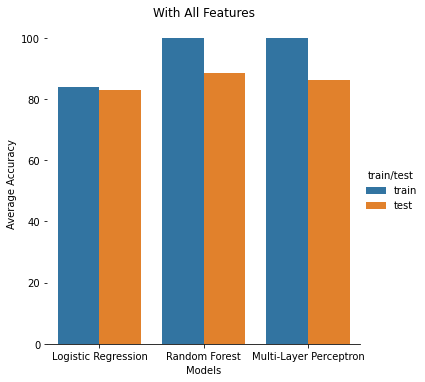

In [117]:
barplot = pd.DataFrame({
    'models': ['Logistic Regression', 'Random Forest', 'Multi-Layer Perceptron', 
               'Logistic Regression', 'Random Forest', 'Multi-Layer Perceptron'],
    'accuracy': [logreg_avg_train, rf_avg_train, nn_avg_train, 
                 logreg_avg_test, rf_avg_test, nn_avg_test],
    'train/test': ['train', 'train', 'train', 'test', 'test', 'test']
})

# Bar plot with all the features
bar = sns.catplot(
    data=barplot, kind='bar',
    x='models', y='accuracy', hue='train/test', ci=None
)
bar.despine(left=True)
bar.set_axis_labels('Models', 'Average Accuracy')
plt.title('With All Features')
plt.show()

Bar plot of mean train and test accuracy of each algorithm in 5-fold cross validation using less features.

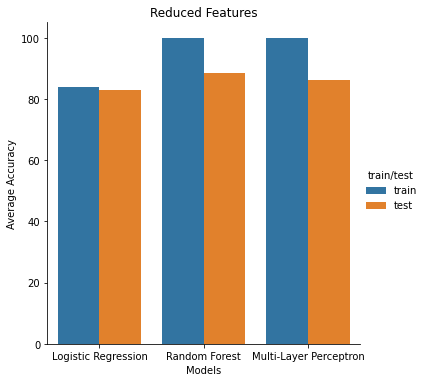

In [118]:
barplot1 = pd.DataFrame({
    'models': ['Logistic Regression', 'Random Forest', 'Multi-Layer Perceptron', 
               'Logistic Regression', 'Random Forest', 'Multi-Layer Perceptron'],
    'accuracy': [logreg_avg_train1, rf_avg_train1, nn_avg_train1, 
                 logreg_avg_test1, rf_avg_test1, nn_avg_test1],
    'train/test': ['train', 'train', 'train', 'test', 'test', 'test']
})

# Bar plot with reduced columns
bar1 = sns.catplot(
    data=barplot, kind='bar',
    x='models', y='accuracy', hue='train/test'
)
bar.despine(left=True)
bar1.set_axis_labels('Models', 'Average Accuracy')
plt.title('Reduced Features')
plt.show()